### Importing Libraries

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

###READ CSV DATA

In [52]:
housing = pd.read_csv('housing.csv')
housing.head()
print(housing.columns)

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')


###Exploring data

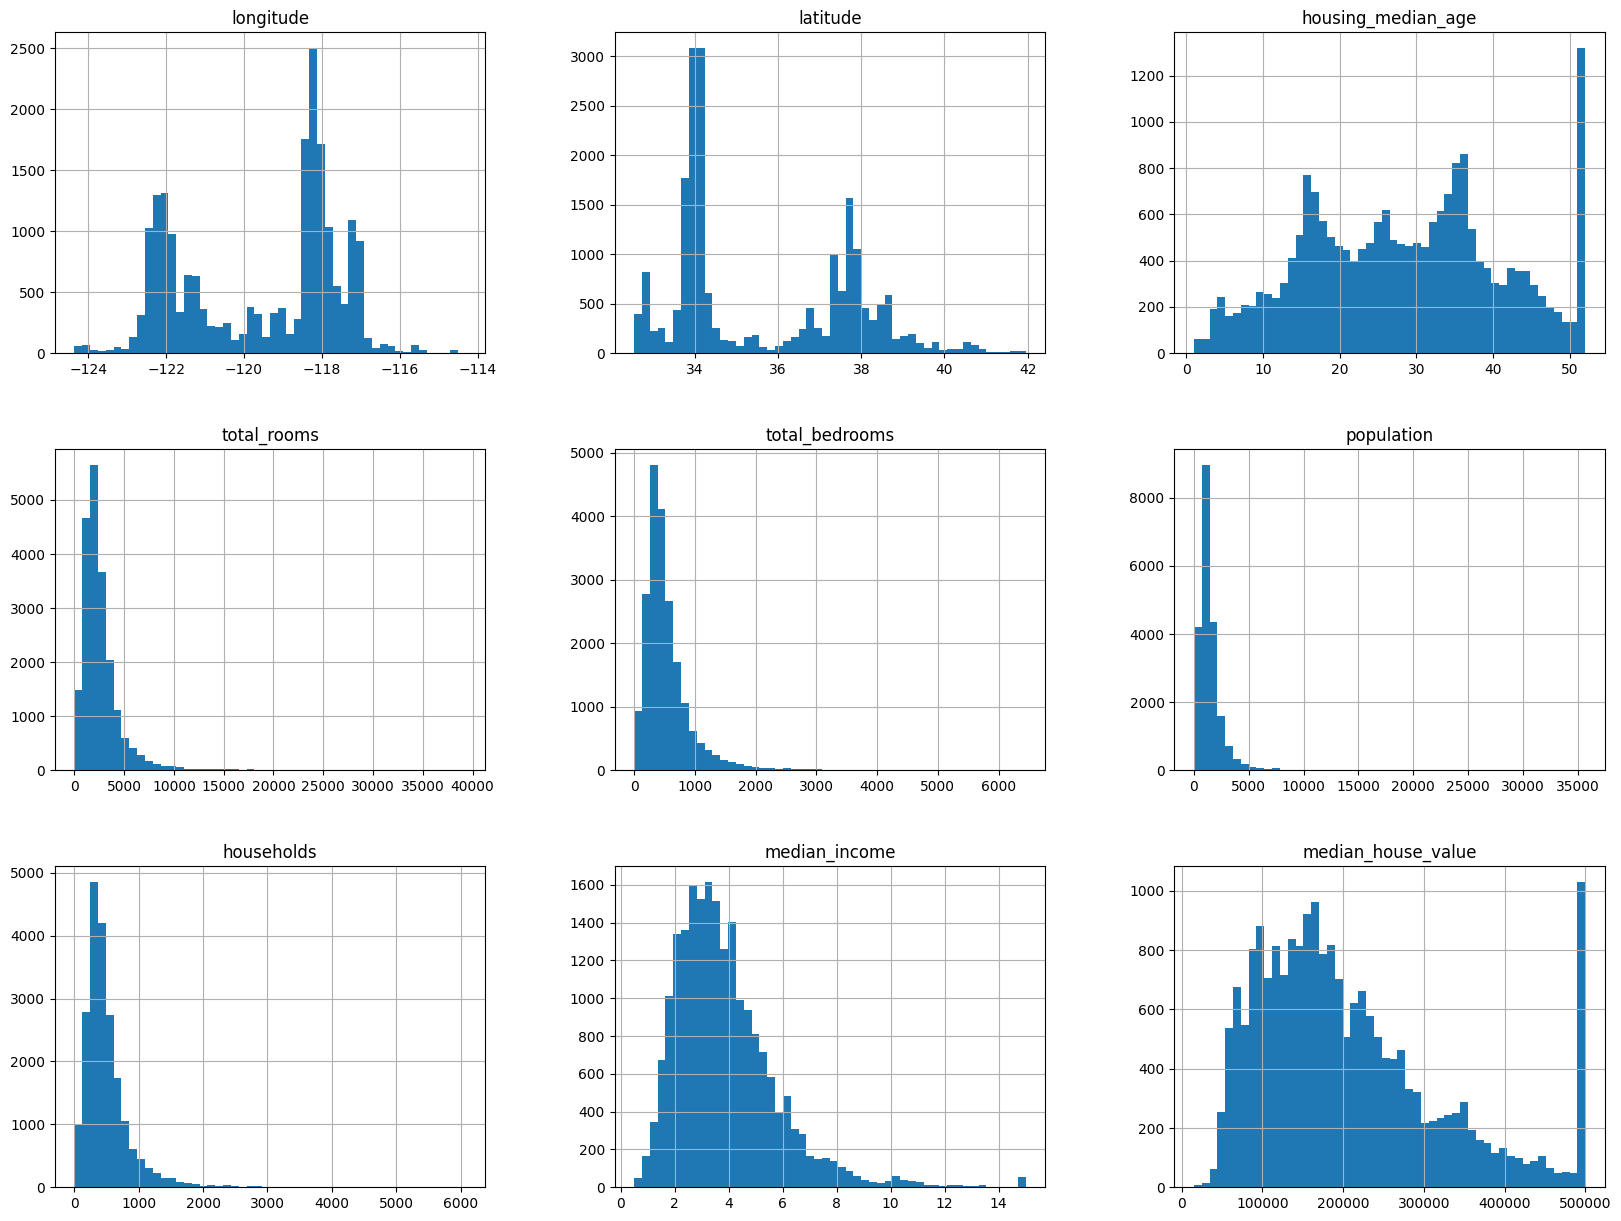

In [53]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [54]:
housing.describe()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


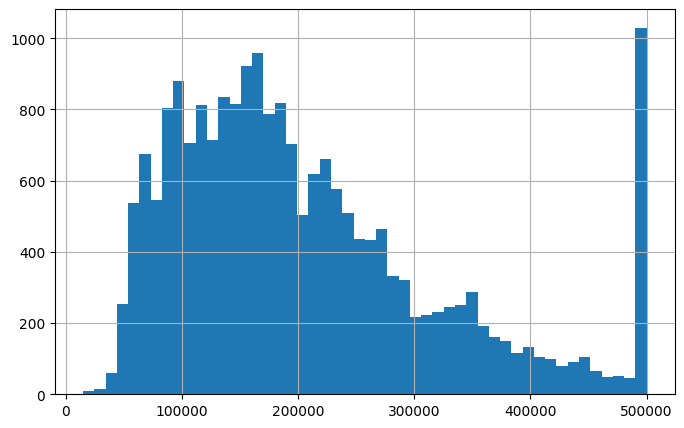

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64


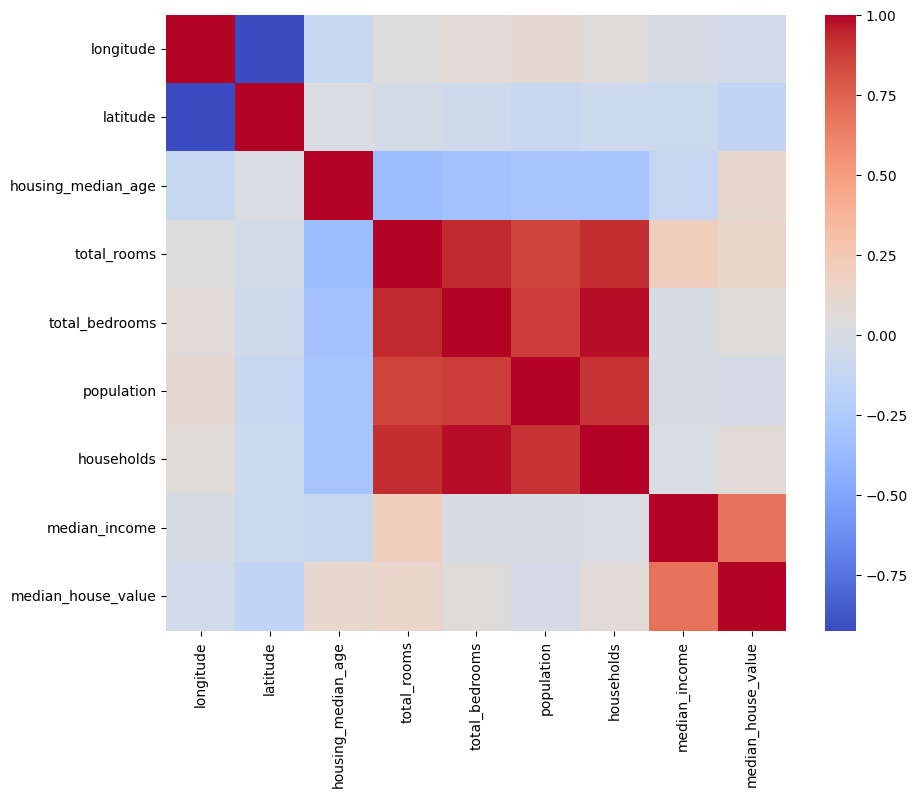

In [55]:
housing["median_house_value"].hist(bins=50, figsize=(8,5))
plt.show()

corr_matrix = housing.corr(numeric_only=True)
print(corr_matrix["median_house_value"].sort_values(ascending=False))

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm")
plt.show()

###Splitting Test and Training data

In [56]:
def split_train_test(data,test_ratio):
  shuffled_indices = np.random.permutation(len(data))
  test_set_size = int(len(data) * test_ratio)
  test_indices = shuffled_indices[:test_set_size]
  train_indices = shuffled_indices[test_set_size:]
  return data.iloc[train_indices], data.iloc[test_indices]
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


###Data Cleaning

In [57]:
# Check missing values
print(housing.isnull().sum())

# Handle missing values in total_bedrooms (example)
imputer = SimpleImputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

# Transform numerical data
X_num = imputer.transform(housing_num)
housing_num = pd.DataFrame(X_num, columns=housing_num.columns)

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64


###Feature Engineering

In [58]:
housing_num["rooms_per_household"] = housing_num["total_rooms"] / housing_num["households"]
housing_num["bedrooms_per_room"] = housing_num["total_bedrooms"] / housing_num["total_rooms"]
housing_num["population_per_household"] = housing_num["population"] / housing_num["households"]
housing_num.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,6.984127,0.146591,2.555556
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,6.238137,0.155797,2.109842
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,8.288136,0.129516,2.802260
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,5.817352,0.184458,2.547945
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,6.281853,0.172096,2.181467


###Encoding Categorical Feature

In [59]:
housing_cat = housing[["ocean_proximity"]]

encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot.toarray()[:5]

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]])

In [60]:
# Combine numerical + categorical
X = np.c_[housing_num, housing_cat_1hot.toarray()]
y = housing["median_house_value"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

###Scaling

In [61]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

###Training Models

####Linear Regression

In [62]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)
y_pred_lin = lin_reg.predict(X_test_scaled)

lin_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lin))
print("Linear Regression RMSE:", lin_rmse)

Linear Regression RMSE: 2.0312210391689993e-10


In [63]:
####Decision Tree

In [64]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train_scaled, y_train)
y_pred_tree = tree_reg.predict(X_test_scaled)

tree_rmse = np.sqrt(mean_squared_error(y_test, y_pred_tree))
print("Decision Tree RMSE:", tree_rmse)

Decision Tree RMSE: 101.44904709743086


###Compare Models

In [65]:
print("RMSE Scores:")
print("Linear Regression:", lin_rmse)
print("Decision Tree:", tree_rmse)

RMSE Scores:
Linear Regression: 2.0312210391689993e-10
Decision Tree: 101.44904709743086
